/liymdata/liym/BLong/scripts/data_collection
2637


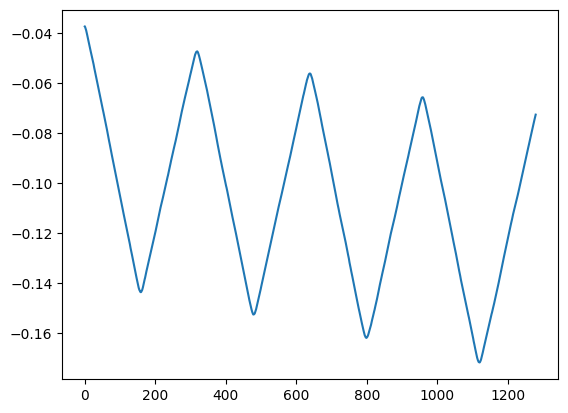

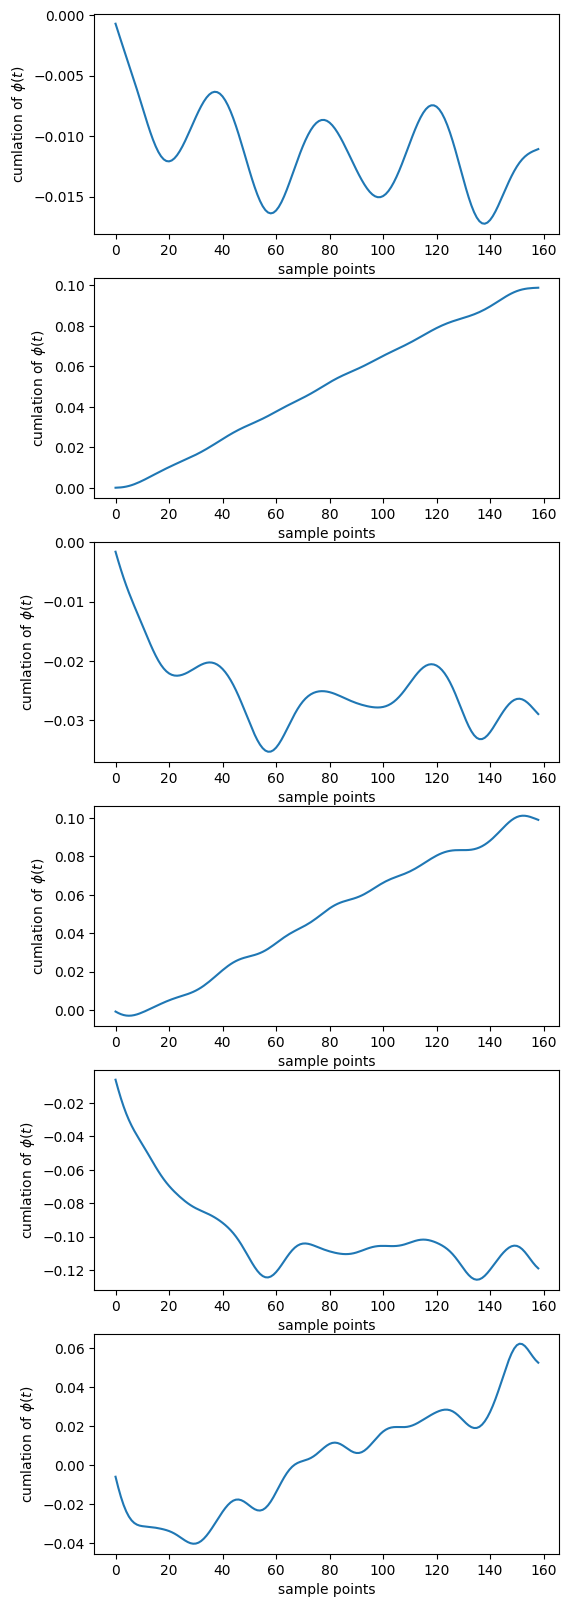

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# from scripts import BLong_preamble_detection as det
# import config

import sys
import os
import scipy 
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + "/../")
print(os.getcwd())
import config
config.sample_rate = 20e6
config.sample_pre_symbol = 20
import BLong_preamble_detection as det




def symbol_add_noise(raw_signal, noise_signal, snr):
    signal_len = raw_signal.shape[1]
    # Then we calculate the power of the preamble signal
    real_signal_power = np.sum(raw_signal.real * raw_signal.real, 1) / signal_len
    imag_signal_power = np.sum(raw_signal.imag * raw_signal.imag, 1) / signal_len
    real_signal_power = real_signal_power.reshape(-1, 1)
    imag_signal_power = imag_signal_power.reshape(-1, 1)
    # Get the power of noise
    real_noise = np.real(noise_signal)
    imag_noise = np.imag(noise_signal)
    real_noise_power = (np.sum(real_noise ** 2, 1)).reshape(-1, 1) / signal_len
    imag_noise_power = (np.sum(imag_noise ** 2, 1)).reshape(-1, 1) / signal_len
    real_noise_var = real_signal_power / (np.power(10., (snr/10)))
    imag_noise_var = imag_signal_power / (np.power(10., (snr/10)))
    real_signal_variance = (np.power(10., (snr/10))) * real_noise_power
    imag_signal_variance = (np.power(10., (snr/10))) * imag_noise_power
    # real_signal = np.sqrt(real_signal_variance / real_signal_power) * raw_signal.real + real_noise
    # imag_signal = np.sqrt(imag_signal_variance / imag_signal_power) * raw_signal.imag + imag_noise
    real_signal = raw_signal.real + np.sqrt(real_noise_var / real_noise_power) * real_noise
    imag_signal = raw_signal.imag + np.sqrt(imag_noise_var / imag_noise_power) * imag_noise
    signal_with_noise = np.zeros((raw_signal.shape[0], raw_signal.shape[1]), dtype=np.complex64)
    signal_with_noise.real = real_signal
    signal_with_noise.imag = imag_signal
    # return signal_with_noise
    b, a = scipy.signal.butter(8, 2e6 / config.sample_rate, "lowpass")
    pad_len = max(len(b), len(a))
    if signal_with_noise.shape[1] <= 3 * pad_len:
        pad_len = (signal_with_noise.shape[1] // pad_len) * pad_len
    else:
        pad_len = 3 * pad_len
    filtered_signal = scipy.signal.filtfilt(b, a, signal_with_noise, axis=1, padlen=pad_len).copy()
    return filtered_signal

if __name__ == "__main__":
    data = np.load("/liymdata/liym/BLong/raw_data/data_chan=0_extf=8.npz")
    raw_signal = data["arr_0"]
    mask = det.get_preamble_mask(extf=8)
    pc_center, corrlation = det.preamble_detection_phase_diff(raw_signal, 8, mask,cluster_size=3)
    centers = np.zeros(len(pc_center), dtype=np.int64)
    for i in range(len(pc_center)):
        corr_val = np.array([corrlation[i, p] for p in pc_center[i]])
        max_idx = np.argmax(corr_val)
        centers[i] = pc_center[i][max_idx]
    # noise_data = torch.randn([1, 8 * config.sample_pre_symbol], dtype=torch.complex64).numpy()
    # noise_data = np.load("/liymdata/liym/BLong/raw_data/white_noise_0_chan=0.npz")["arr_0"][10:11, 0:8*config.sample_pre_symbol]
    noise_data = np.load("/liymdata/liym/BLong/raw_data/white_noise.npy")[10:11, 0:8*config.sample_pre_symbol]
    # plt.figure()
    # plt.plot(noise_data[0, :].real)
    native_preamble_idx = centers - 8 * config.sample_pre_symbol * 7
    native_phase_diff = det.cal_phase_diff(raw_signal)
    native_phase_cum = np.cumsum(native_phase_diff, axis=1)
    plt.figure()
    plt.plot(native_phase_cum[0, centers[0]:centers[0]+8*8*20])
    print(centers[0])

    plt.figure(figsize=(6, 20))
    f_c = 1
    for db in [10, 0, -10]:
        # plt.rc('font',family='Arial', size=12)
        native_noise_data = symbol_add_noise(raw_signal[0:1, native_preamble_idx[0]: native_preamble_idx[0]+8*config.sample_pre_symbol], noise_data, db)
        native_phase_diff = det.cal_phase_diff(native_noise_data)
        native_phase_cum = np.cumsum(native_phase_diff, axis=1)
        ext_noise_data = symbol_add_noise(raw_signal[0:1, centers[0]+160: centers[0]+320], noise_data, db)
        ext_phase_diff = det.cal_phase_diff(ext_noise_data)
        ext_phase_cum = np.cumsum(ext_phase_diff, axis=1)
    
        plt.subplot(6, 1, f_c)
        plt.plot(native_phase_cum[0, ])
        plt.xlabel("sample points")
        plt.ylabel("cumlation of $\phi(t)$")
        plt.subplot(6, 1, f_c+1)
        plt.plot(ext_phase_cum[0, ])
        plt.ylabel("cumlation of $\phi(t)$")
        plt.xlabel("sample points")
        f_c += 2
        # np.savetxt("./output_figs/dsss_ext_compare_" + str(db) + ".csv", np.vstack((native_phase_cum, ext_phase_cum)), delimiter=',')
    # plt.savefig("./output_figs/dsss_ext_compare" + ".pdf")
